# **DeePTB** V2.0 | NRL-TB 参数化使用案例

<div style="color:black; background-color:#FFF3E9; border: 1px solid #FFE0C3; border-radius: 10px; margin-bottom:1rem">
    <p style="margin:1rem; padding-left: 1rem; line-height: 2.5;">
        ©️ <b><i>Copyright 2024 @ Authors</i></b><br/>
        作者: <a style="font-weight:normal" href="mailto:guqq@pku.edu.cn">顾强强 📨 </a> </a></b></i><br/>
        日期：2024-04-09<br/>
        共享协议：本作品采用<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">知识共享署名-非商业性使用-相同方式共享 4.0 国际许可协议</a>进行许可。</i><br/>
        快速开始：点击上方的 <span style="background-color:rgb(85, 91, 228); color:white; padding: 3px; border-radius: 5px;box-shadow: 2px 2px 3px rgba(0, 0, 0, 0.3); font-size:0.75rem;">开始连接</span> 按钮，稍等片刻即可运行。
    </p>
</div>

<p style="color:purple; font-weight:bold">DeePTB是使用深度学习构建第一性原理精度的紧束缚（TB）模型的方法，可用于加速材料的电子结构计算。目前该软件已经迭代更新至v2.0 版本。</p>

**本教程主要介绍DeePTB 如何读取转换NRL TB 参数、加载模型及模型优化训练**

完成本案例你将：
1. 了解 NRL-TB 方法的基本知识
2. 了解 DeePTB 加载NRL-TB 参数的方法 

关联阅读: **DeePTB** V2.0 快速上手指南 | 训练 Silicon 的紧束缚模型模型

## 1. NRL-TB 简介

NRL-TB 是一种基于紧束缚方法的电子结构计算方法，它是由美国海军研究实验室（NRL）开发的。NRL-TB 方法的基本思想是将晶体的电子结构问题转化为一个紧束缚模型，通过求解紧束缚模型的本征值问题来获得晶体的电子结构信息。NRL-TB 方法的优点是可以通过调整紧束缚模型的参数来模拟不同的晶体结构，从而实现对晶体的电子结构计算。

目前该参数化方法已经被整合到 DeePTB 中，可以通过 DeePTB 加载 NRL-TB 参数来进行电子结构计算。

了解更多 NRL-TB 信息，请阅读相关文献如 N. Bernstein, et. al. Phys. Rev. B 62, 4477 (2000).


## 2. DeePTB 转换 NRL-TB 参数

In [2]:
import os
os.chdir('./examples/NRL-TB/silicon')

In [3]:
ls

Si_sp.par           in_band.json        nrl_out/            plot_json_v2.ipynb
Si_spd.par          input_n2j.json      nrlspd/             plot_v2.ipynb
band/               input_sp.json       nrlspd_frzoverlap/  run.sh
bandstructure.npy   input_spd.json      outv2/              v1/
data/               input_spd_fz.json   outv2spd/


In [4]:
!dptb n2j -h

usage: dptb n2j [-h] [-v {DEBUG,3,INFO,2,WARNING,1,ERROR,0}] [-l LOG_PATH]
                [-nrl NRL_FILE] [-o OUTDIR]
                INPUT

positional arguments:
  INPUT                 the input parameter file in json or yaml format

optional arguments:
  -h, --help            show this help message and exit
  -v {DEBUG,3,INFO,2,WARNING,1,ERROR,0}, --log-level {DEBUG,3,INFO,2,WARNING,1,ERROR,0}
                        set verbosity level by string or number, 0=ERROR,
                        1=WARNING, 2=INFO and 3=DEBUG (default: INFO)
  -l LOG_PATH, --log-path LOG_PATH
                        set log file to log messages to disk, if not
                        specified, the logs will only be output to console
                        (default: None)
  -nrl NRL_FILE, --nrl_file NRL_FILE
                        The NRL file name (default: None)
  -o OUTDIR, --outdir OUTDIR
                        The output files to save the transfered model and
                        updated input.

In [6]:
!dptb n2j input_n2j.json -nrl Si_spd.par -o nrl_out

DEEPTB INFO    System: Silicon (Si) -- full spd parametrization -- onsite t2g=eg -- 22 October 1999
DEEPTB INFO    num of atom type: 1
DEEPTB INFO    The NRL parameters are successfully transferred to DPTB.
DEEPTB INFO    Please check the input json file and modify the parameters if necessary.
DEEPTB INFO    !!!!!
DEEPTB INFO    Important: recommend to set the info.json r_max and oer_max >= 6.6147151362875 Ang
DEEPTB INFO    !!!!!
DEEPTB INFO    NRL file Si_spd.par has been converted to nrl_out/nrl_ckpt.json.
DEEPTB INFO    INPUT json is updated to nrl_out/input_nrl_auto.json.
DEEPTB INFO    Please check the json file and modify the parameters if necessary.


In [7]:
ls  ./nrl_out

input_nrl_auto.json  nrl_ckpt.json


## 3. DeePTB 加载 NRL-TB 参数，绘制能带

In [7]:
from dptb.nn.build import build_model
from dptb.postprocess.bandstructure.band import Band
import  matplotlib.pyplot  as plt
import numpy as np
from ase.io import read
from dptb.data import AtomicData, AtomicDataDict
from dptb.nn.nnsk import NNSK
import json
import torch


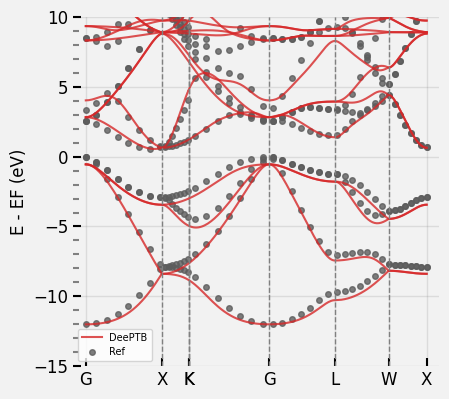

In [26]:
#set the band structure task
model = build_model(checkpoint= "./nrl_out/nrl_ckpt.json")

jdata={   
    "task_options": {
        "task": "band",
        "kline_type":"abacus",
        "kpath":[[0.0000000000,  0.0000000000,   0.0000000000,   50],   
                [0.5000000000,   0.0000000000,   0.5000000000,   50],               
                [0.6250000000,   0.2500000000,   0.6250000000,   1],    
                [0.3750000000,   0.3750000000,   0.7500000000,   50],     
                [0.0000000000,   0.0000000000,   0.0000000000,   50],    
                [0.5000000000,   0.5000000000,   0.5000000000,   50],                
                [0.5000000000,   0.2500000000,   0.7500000000,   50],               
                [0.5000000000,   0.0000000000,   0.5000000000,   1 ]
                ],
        "klabels":["G","X","X/U","K","G","L","W","X"],
        "nel_atom":{"Si":4},
        "E_fermi":5.832744121551514,
        "emin":-15,
        "emax":10,
        "ref_band": "./data/kpath.0/eigenvalues.npy"
    }
}

stru_data = "./data/silicon.vasp"
AtomicData_options = {"r_max": 5.0, "oer_max":6.6147151362875, "pbc": True}

kpath_kwargs = jdata["task_options"]
bcal = Band(model=model, 
            use_gui=True, 
            results_path='./', 
            device=model.device)

eigenstatus = bcal.get_bands(data=stru_data, 
               kpath_kwargs=kpath_kwargs, 
               AtomicData_options=AtomicData_options)


bcal.band_plot(ref_band = kpath_kwargs["ref_band"],
               E_fermi = kpath_kwargs["E_fermi"],
               emin = kpath_kwargs["emin"],
               emax = kpath_kwargs["emax"])

## 4. DeePTB 模型优化训练

In [25]:
! dptb train input_spd_fz.json -i ./nrl_out/nrl_ckpt.json -o ./nrl_train_fz

Processing dataset...
Loading data:   0%|                                       | 0/1 [00:00<?, ?it/s]/Users/aisiqg/Software/venv/pydptb/lib/python3.9/site-packages/dptb/data/AtomicData.py:922: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  cell_tensor = torch.as_tensor(temp_cell, device=out_device, dtype=out_dtype)
Loading data: 100%|███████████████████████████████| 1/1 [00:00<00:00, 17.01it/s]
DEEPTB INFO    Loaded data: Batch(atomic_numbers=[2, 1], batch=[2], bwindow=[1, 2], cell=[1, 3, 3], edge_cell_shift=[92, 3], edge_features=[92, 1], edge_index=[2, 92], edge_overlap=[92, 1], e

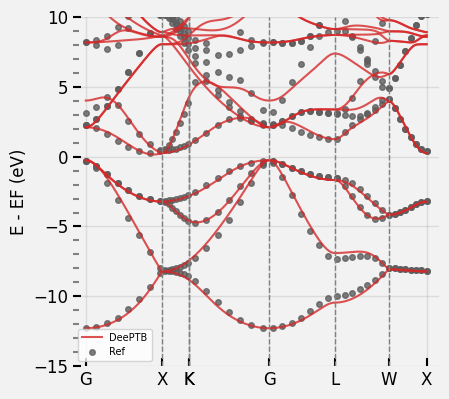

In [29]:
#set the band structure task
model = build_model(checkpoint= "./nrl_train_fz/checkpoint/nnsk.ep100.pth")

jdata={   
    "task_options": {
        "task": "band",
        "kline_type":"abacus",
        "kpath":[[0.0000000000,  0.0000000000,   0.0000000000,   50],   
                [0.5000000000,   0.0000000000,   0.5000000000,   50],               
                [0.6250000000,   0.2500000000,   0.6250000000,   1],    
                [0.3750000000,   0.3750000000,   0.7500000000,   50],     
                [0.0000000000,   0.0000000000,   0.0000000000,   50],    
                [0.5000000000,   0.5000000000,   0.5000000000,   50],                
                [0.5000000000,   0.2500000000,   0.7500000000,   50],               
                [0.5000000000,   0.0000000000,   0.5000000000,   1 ]
                ],
        "klabels":["G","X","X/U","K","G","L","W","X"],
        "nel_atom":{"Si":4},
        "E_fermi":5.832744121551514,
        "emin":-15,
        "emax":10,
        "ref_band": "./data/kpath.0/eigenvalues.npy"
    }
}

stru_data = "./data/silicon.vasp"
AtomicData_options = {"r_max": 5.0, "oer_max":6.6147151362875, "pbc": True}

kpath_kwargs = jdata["task_options"]
bcal = Band(model=model, 
            use_gui=True, 
            results_path='./', 
            device=model.device)

eigenstatus = bcal.get_bands(data=stru_data, 
               kpath_kwargs=kpath_kwargs, 
               AtomicData_options=AtomicData_options)


bcal.band_plot(ref_band = kpath_kwargs["ref_band"],
               E_fermi = kpath_kwargs["E_fermi"],
               emin = kpath_kwargs["emin"],
               emax = kpath_kwargs["emax"])